# **ECE-472 Deep Learning Midterm Project**
## Unconditional Diffusion Model on CIFAR100
Ravindra Bisram and Danny Hong

# Imports/Helper Functions
These blocks are the same for both regular UNET and conditional UNET


In [ ]:
# Required libraries to install
!pip install tensorflow
!pip install tensorflow_datasets
!pip install tensorflow_addons
!pip install einops

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math
from tensorflow.keras.layers import LayerNormalization as LayerNorm
from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial

tf.get_logger().setLevel("ERROR")

In [ ]:
target_size = (32, 32)
channels = 1
BATCH_SIZE = 64
CONDITIONAL = True

if not CONDITIONAL:
  def preprocess(x, y):
      return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, target_size)
else:
  def preprocess(x, y):
      return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, target_size), tf.cast(y, tf.int32)

def get_datasets(name="MNIST"):
    if name is "MNIST":
      # Load in the MNIST dataset
      train_ds = tfds.load('mnist', as_supervised=True, split="train")
      # Normalize to [-1, 1], shuffle and batch
      train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)

    else:
      train_ds = tfds.load('cifar100', as_supervised=True, split="train")
      train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)


    train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Return numpy arrays instead of TF tensors while iterating
    return tfds.as_numpy(train_ds)


train_ds_M = get_datasets(name="MNIST")
train_ds_C = get_datasets(name="CIFAR")

In [ ]:
# T
timesteps = 1000

# Create a fixed linear beta (variance) schedule from β1 = 10−4 to βT = 0.02
# as per DDPM paper, later improvements use a cosine scheduler -> possible future
# work.
beta = np.linspace(0.0001, 0.02, timesteps)

# Reparameterization that allows us to work around inefficiently iterating through
# the entire Markov chain for every timestep. The sum of two Gaussian samples
# is also a Gaussian sample. 
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

def set_key(key):
    '''Set numpy RNG key'''
    np.random.seed(key)

def forward_noise(key, x_0, t):
    '''Adds noise to the input as per the given timestamp, using the reparamaterization trick'''
    set_key(key)
    noise = np.random.normal(size = x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

def generate_timestamp(key, num):
    '''Generate sample timestamps between 0 & T'''
    set_key(key)
    return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

(32, 32, 1)


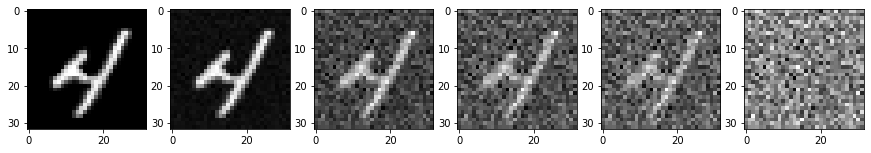

(32, 32, 3)


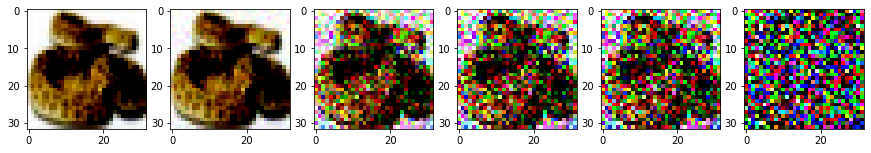

In [ ]:
# Visualizing the forward noising process at a few random timesteps

def visualize_forward_noise(dataset, name="MNIST"):
  sample_data = next(iter(dataset))[0][0]
  print(sample_data.shape)
  fig = plt.figure(figsize=(15, 30))

  for index, i in enumerate([0, 10, 100, 150, 195, 999]):
      noisy_im, noise = forward_noise(0, np.expand_dims(sample_data, 0), np.array([i,]))
      plt.subplot(1, 6, index+1)
      
      if name is "MNIST":
        plt.imshow(np.squeeze(np.squeeze(noisy_im, -1), 0), cmap='gray')
      else:
        plt.imshow(np.squeeze(noisy_im, 0))

  plt.show()

visualize_forward_noise(train_ds_M, name="MNIST")
visualize_forward_noise(train_ds_C, name="CIFAR100")

In [ ]:
# Helper functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

# Use Sinusoidal positional embeddings to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb
        
# Layer Modules to build the blocks
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)

class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm()

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size = 4, strides = 2, padding = 'SAME')

def Downsample(dim):
    return nn.Conv2D(filters = dim, kernel_size = 4, strides = 2, padding='SAME')

In [ ]:
# Build the block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size = 3, strides = 1, padding = 'SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon = 1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=-1)

        h = self.block1(x, gamma_beta=gamma_beta, training=training)
        h = self.block2(h, training=training)
        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            LayerNorm()
        ])

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out)

        return out

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head = 32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1)

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis = -1), axis = -1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training = training)

        return out

# Class Conditioning layer allows for Conditional Diffusion
class ClassConditioning(Layer):
    def __init__(self, res, num_channels = 1):
        super().__init__()
        self.block = Sequential([
            nn.Dense(res * res * num_channels),
            SiLU(),
            nn.Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):
        return self.block(x)

In [ ]:
# Implementation of ddpm to remove noise
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

# Standard (Unconditional) UNET Model



In [ ]:
class Unet(Model):
    def __init__(self,
                 dim = 64,
                 init_dim = None,
                 out_dim = None,
                 dim_mults = (1, 2, 4, 8),
                 channels = 3,
                 resnet_block_groups = 8,
                 learned_variance = False,
                 sinusoidal_cond_mlp = True
                 ):
        super(Unet, self).__init__()
        
        # determine dimensions
        self.channels = channels
        
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp
        
        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            GELU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")
        
        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out, dim_out, time_emb_dim = time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])
  
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])
        
        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)
        
        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size = 1, strides = 1)
        ], name="output")
        
    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis = -1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)
        x = tf.concat([x, h.pop()], axis = -1)
        x = self.final_conv(x)
        return x

In [ ]:
# Create UNET model
channels = 1
unet = Unet(channels = channels)

# Checkopint manager
ckpt = tf.train.Checkpoint(unet=unet)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep = 2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

# initialize the model
test_images = np.ones([1, 32, 32, channels])
test_timestamps = generate_timestamp(0, 1)
k = unet(test_images, test_timestamps)

# create optimizer, we use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate = 1e-4)

Restored from ./checkpoints/ckpt-3


In [ ]:
# Using the MSE as the loss function
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

rng = 0

# Unconditional train_step
def train_step_unconditional(batch):
    rng, tsrng = np.random.randint(0, 100000, size = (2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

In [ ]:
#Function to train the model (unconditional)
def train_unconditional(train_ds, epochs):
  for e in range(1, epochs+1):
      bar = tf.keras.utils.Progbar(len(train_ds)-1)
      losses = []
      for i, batch in enumerate(iter(train_ds)):
          loss = train_step_unconditional(batch)
          losses.append(loss)
          bar.update(i, values=[("loss", loss)])

      avg = np.mean(losses)
      print(f"Average loss for epoch {e}/{epochs}: {avg}")
      ckpt_manager.save(checkpoint_number=e)

In [ ]:
# Showing the denoising process iteratively
def show_denoising_unconditional(x, img_list, timesteps, dataset):
  for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps -i - 1, np.int32), 0)
    pred_noise = unet(x, t)
    x = ddpm(x, pred_noise, t)
    
    if dataset = 'MNIST':
      img_list.append(np.squeeze(np.squeeze(x, 0), -1))

      if i % 25 == 0:
      plt.imshow(np.squeeze(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8)), cmap = "gray")
      plt.show()
    
    if dataset = 'CIFAR100':
      img_list.append(np.squeeze(x, 0))

      if i % 200 == 0:
        plt.imshow(np.squeeze(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8)))
        plt.show()

  plt.imshow(np.squeeze(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8)))
  plt.show()

# Unconditional MNIST

In [ ]:
train_unconditional(train_ds_M, epochs = 10)

937/937 [==============================] - 500s 530ms/step - loss: 0.2522
Average loss for epoch 1/10: 0.25221842527389526
937/937 [==============================] - 488s 520ms/step - loss: 0.0882
Average loss for epoch 2/10: 0.08815757185220718
937/937 [==============================] - 483s 515ms/step - loss: 0.0707
Average loss for epoch 3/10: 0.07065674662590027
937/937 [==============================] - 477s 508ms/step - loss: 0.0628
Average loss for epoch 4/10: 0.06282152980566025
937/937 [==============================] - 480s 512ms/step - loss: 0.0575
Average loss for epoch 5/10: 0.057548705488443375
937/937 [==============================] - 476s 508ms/step - loss: 0.0531
Average loss for epoch 6/10: 0.05308779329061508
937/937 [==============================] - 476s 507ms/step - loss: 0.0500
Average loss for epoch 7/10: 0.04999472573399544
937/937 [==============================] - 476s 507ms/step - loss: 0.0471
Average loss for epoch 8/10: 0.047096047550439835
937/937 [=====

  0%|          | 0/199 [00:00<?, ?it/s]

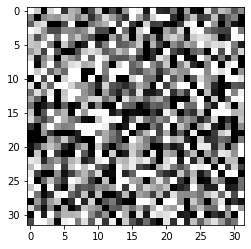

 13%|█▎        | 25/199 [00:07<00:36,  4.71it/s]

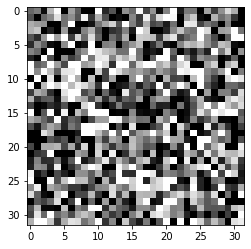

 25%|██▌       | 50/199 [00:12<00:30,  4.82it/s]

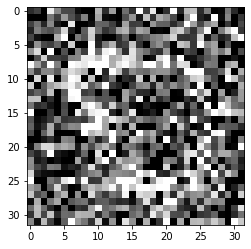

 38%|███▊      | 75/199 [00:18<00:25,  4.81it/s]

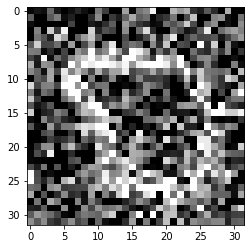

 50%|█████     | 100/199 [00:23<00:20,  4.75it/s]

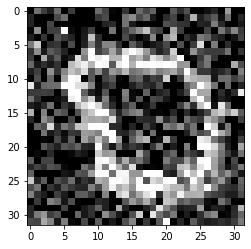

 63%|██████▎   | 125/199 [00:29<00:15,  4.73it/s]

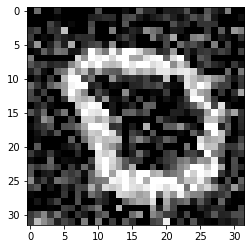

 75%|███████▌  | 150/199 [00:34<00:10,  4.76it/s]

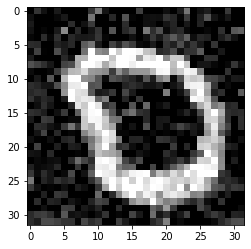

 88%|████████▊ | 175/199 [00:39<00:05,  4.72it/s]

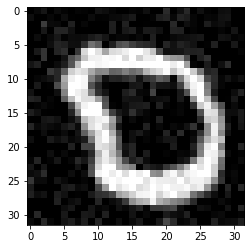

100%|██████████| 199/199 [00:44<00:00,  4.43it/s]


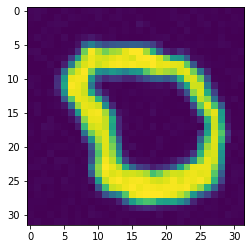

In [ ]:
x = tf.random.normal((1, 32, 32, 1))
img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0), -1))

show_denoising_unconditional(x, img_list, timesteps, dataset = 'MNIST')

# Unconditional CIFAR 100


In [ ]:
train_unconditional(train_ds_C, epochs=3)

781/781 [==============================] - 425s 539ms/step - loss: 0.0409
Average loss for epoch 1/3: 0.04087378457188606
781/781 [==============================] - 415s 530ms/step - loss: 0.0395
Average loss for epoch 2/3: 0.039482057094573975
781/781 [==============================] - 411s 525ms/step - loss: 0.0387
Average loss for epoch 3/3: 0.03873465210199356


  0%|          | 0/999 [00:00<?, ?it/s]

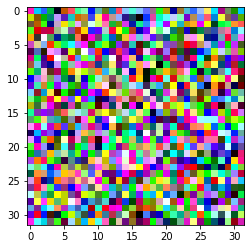

 20%|██        | 200/999 [00:43<02:54,  4.58it/s]

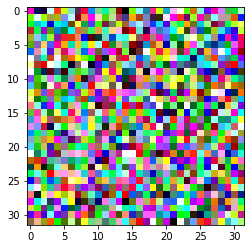

 40%|████      | 400/999 [01:26<02:08,  4.68it/s]

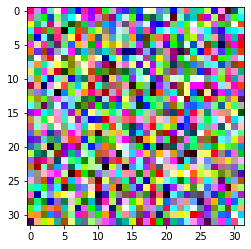

 60%|██████    | 600/999 [02:09<01:27,  4.55it/s]

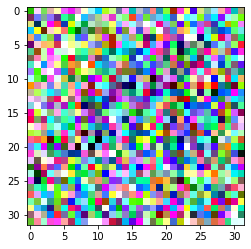

 80%|████████  | 800/999 [02:53<00:42,  4.65it/s]

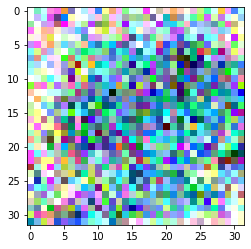

100%|██████████| 999/999 [03:36<00:00,  4.62it/s]


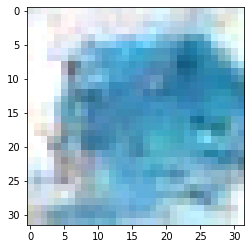

In [ ]:
x = tf.random.normal((1, 32, 32, 3))
img_list = []
img_list.append(np.squeeze(x, 0))

show_denoising_unconditional(x, img_list, timesteps, dataset = 'CIFAR100')

# Conditional UNET

In [ ]:
class Unet_conditional(Model):
    def __init__(self,dim = 64,
                 init_dim = None,
                 out_dim = None,
                 dim_mults = (1, 2, 4, 8),
                 channels = 3,
                 resnet_block_groups = 8,
                 learned_variance = False,
                 sinusoidal_cond_mlp = True,
                 num_classes = None,
                 class_embedder = None,
                 class_emb_dim = 64,
                 in_res = 64,
                 ):
      
        super(Unet_conditional, self).__init__()
        
        # Determine dimensions
        self.channels = channels
        self.in_res = in_res

        # Generate the class embeddings 
        self.class_embeddings = nn.Embedding(num_classes, class_emb_dim) if class_embedder is None else class_embedder

        init_dim = default(init_dim, dim // 3 * 2)
        
        # INITIAL CONV
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME', data_format='channels_last')
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        print("Building a MLP")
        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            GELU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")
        print("Done Building MLP")
        
        
        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)
        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            print(is_last)
            self.downs.append([
                ClassConditioning(now_res),
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1
  
        mid_dim = dims[-1]
        self.mid_class_conditioning = ClassConditioning(now_res)
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                ClassConditioning(now_res),
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)
        
        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")
        
    def call(self, x, time=None, class_vector=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        class_vector = self.class_embeddings(class_vector)
        h = []
        
        i = 0
        for class_conditioning, block1, block2, attn, downsample in self.downs:
            cv = class_conditioning(class_vector)
            x = tf.concat([x, cv], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
            i = i + 1

        cv = self.mid_class_conditioning(class_vector)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for class_conditioning, block1, block2, attn, upsample in self.ups:
            cv = class_conditioning(class_vector)
            x = tf.concat([x, cv], axis=-1)
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [ ]:
unet_con = None
unet_con = Unet_conditional(
    num_classes = 10,
    in_res = 32,
    channels = 1
)

ckpt = tf.train.Checkpoint(unet=unet_con)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints/conditional_diffusion/", max_to_keep = 2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)
test_class = np.array([3], dtype=np.int32)
k = unet_con(test_images, test_timestamps, test_class)

opt = keras.optimizers.Adam(learning_rate = 1e-4)
print(unet_con.summary())

Building a MLP
Done Building MLP
False
False
False
True
Restored from ./checkpoints/conditional_diffusion/ckpt-1
Model: "unet_conditional_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    multiple                  640       
                                                                 
 conv2d_3800 (Conv2D)        multiple                  2100      
                                                                 
 time embeddings (Sequential  (1, 256)                 82432     
 )                                                               
                                                                 
 class_conditioning_472 (Cla  multiple                 66560     
 ssConditioning)                                                 
                                                                 
 resnet_block_1020 (ResnetBl  multiple                 97728     


In [ ]:
def train_step(batch, _class):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, timestep_values)
    with tf.GradientTape() as tape:
        prediction = unet_con(noised_image, timestep_values, _class)
        
        loss_value = loss_fn(noise, prediction)
    
    gradients = tape.gradient(loss_value, unet_con.trainable_variables)
    opt.apply_gradients(zip(gradients, unet_con.trainable_variables))

    return loss_value

In [ ]:
def show_denoising(x, img_list, _class):
  for i in tqdm(range(timesteps - 1)):
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet_con(x, t, np.array([_class], dtype=np.int32))
    x = ddpm(x, pred_noise, t)
    img_list.append(np.squeeze(np.squeeze(x, 0), -1))

    if i % 25 == 0:
        plt.imshow(np.squeeze(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8)), cmap = "gray")
        plt.show()

  plt.imshow(np.squeeze(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8)))
  plt.show()

In [ ]:
epochs = 5

for epoch in range(1, epochs+1):

    bar = tf.keras.utils.Progbar(len(train_ds)-1)
    losses = []

    # Iterate over the batches of the dataset.
    for i, batch in enumerate(iter(train_ds)):
        loss = train_step(batch[0], batch[1])
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    print(f"Average loss for epoch {epoch}/{epochs}: {avg}")
    ckpt_manager.save(checkpoint_number=e)

937/937 [==============================] - 514s 547ms/step - loss: 0.0912
Average loss for epoch 1/5: 0.09115394949913025
937/937 [==============================] - 513s 547ms/step - loss: 0.0642
Average loss for epoch 2/5: 0.06421485543251038
937/937 [==============================] - 508s 541ms/step - loss: 0.0563
Average loss for epoch 3/5: 0.0563461035490036
937/937 [==============================] - 495s 528ms/step - loss: 0.0521
Average loss for epoch 4/5: 0.052058178931474686
937/937 [==============================] - 497s 530ms/step - loss: 0.0478
Average loss for epoch 5/5: 0.04778379201889038


  0%|          | 0/199 [00:00<?, ?it/s]

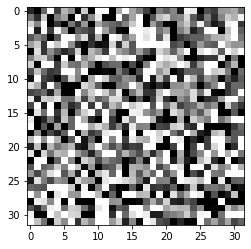

 13%|█▎        | 25/199 [00:06<00:39,  4.42it/s]

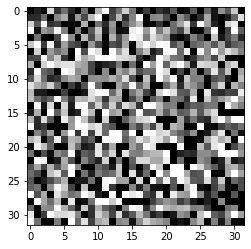

 25%|██▌       | 50/199 [00:12<00:34,  4.28it/s]

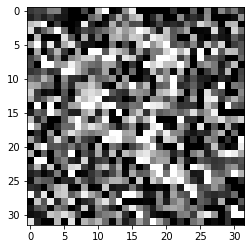

 38%|███▊      | 75/199 [00:18<00:28,  4.40it/s]

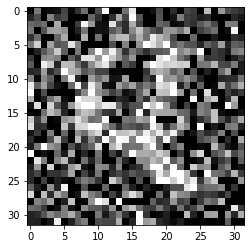

 50%|█████     | 100/199 [00:24<00:22,  4.41it/s]

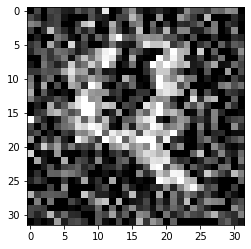

 63%|██████▎   | 125/199 [00:30<00:16,  4.36it/s]

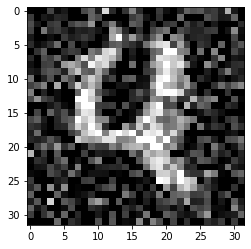

 75%|███████▌  | 150/199 [00:35<00:11,  4.41it/s]

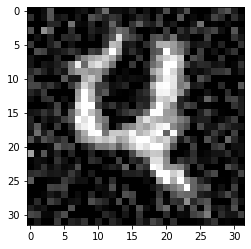

 88%|████████▊ | 175/199 [00:41<00:05,  4.43it/s]

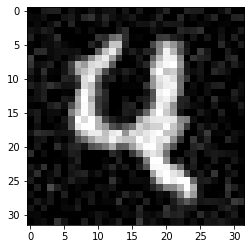

100%|██████████| 199/199 [00:47<00:00,  4.21it/s]


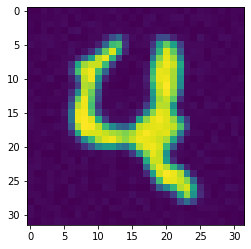

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
x = tf.random.normal((1,32,32,1))

img_list = []
img_list.append(np.squeeze(np.squeeze(x, 0), -1))

show_denoising(x, img_list, _class = 4)

In [ ]:
!zip -r ./mnist-diffusion-weights.zip ./checkpoints
from google.colab import files
files.download("./mnist-diffusion-weights.zip")

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/conditional_diffusion/ (stored 0%)
  adding: checkpoints/conditional_diffusion/checkpoint (deflated 54%)
  adding: checkpoints/conditional_diffusion/ckpt-5.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/conditional_diffusion/ckpt-4.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/conditional_diffusion/ckpt-5.index (deflated 78%)
  adding: checkpoints/conditional_diffusion/ckpt-4.index (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>